# Sentinel-5P NO2 Analysis - Copernicus Data Space

In [1]:
import openeo
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

## Koneksi ke dataset Copernicus Data Space

In [2]:
conn = openeo.connect("https://openeo.dataspace.copernicus.eu").authenticate_oidc()

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=BQEQ-MNUO 📋 to authenticate.

[###################################--] ⌛ Authorization pending

KeyboardInterrupt: 

## Koordinat Area of Interest (AOI)

setelah berhasil koneksi ke copernicus maka selanjutnya memasukkan koordinat area yang ingin diambil datanya


In [3]:
aoi = {
    "type": "Polygon",
    "coordinates": [[
        [106.97546085598384, -6.19537831957436],
        [106.97546085598384, -6.3333337482497996],
        [107.18719969023448, -6.3333337482497996],
        [107.18719969023448, -6.19537831957436],
        [106.97546085598384, -6.19537831957436],
    ]]
}

## Load Sentinel-5P NO2 Data

setelah area di tentukan maka akan memproses data NO2 dari kurun waktu yang sudah ditentukan untuk dibandingkan nanti


In [4]:
no2_before = conn.load_collection(
    "SENTINEL_5P_L2",
    spatial_extent=aoi,
    temporal_extent=["2019-01-01", "2019-12-31"],
    bands=["NO2"]
)

no2_after = conn.load_collection(
    "SENTINEL_5P_L2",
    spatial_extent=aoi,
    temporal_extent=["2021-01-01", "2021-12-31"],
    bands=["NO2"]
)

## Reduce Spatially & Convert to Pandas

Langkah ini bertujuan untuk menyederhanakan data spasial sebelum dianalisis lebih lanjut. Reduce Spatially berarti melakukan peringkasan atau agregasi data yang bersifat spasial, misalnya citra satelit atau data geospasial, sehingga informasi yang sangat detail dapat diringkas menjadi bentuk yang lebih sederhana, seperti menghitung rata-rata, maksimum, atau jumlah nilai dalam suatu wilayah tertentu. Setelah data diringkas, langkah selanjutnya adalah Convert to Pandas, yaitu mengubah data hasil agregasi menjadi format DataFrame Pandas. Dengan format ini, data menjadi lebih mudah dikelola, dianalisis, dan divisualisasikan menggunakan fungsi-fungsi tabular yang tersedia di Pandas. Proses ini memungkinkan integrasi data spasial yang kompleks ke dalam workflow analisis data yang lebih umum dan fleksibel.

In [5]:
reducer = "mean"

# Gunakan aggregate_spatial untuk menghitung rata-rata di dalam AOI
no2_before_mean = no2_before.aggregate_spatial(geometries=aoi, reducer=reducer)
no2_after_mean = no2_after.aggregate_spatial(geometries=aoi, reducer=reducer)

print("Memulai job untuk data 2019 (before)...")
before_job = no2_before_mean.execute_batch()
print("Memulai job untuk data 2021 (after)...")
after_job = no2_after_mean.execute_batch()

before_filename = "no2_before_covid.json"
after_filename = "no2_after_covid.json"

print(f"Mengunduh hasil 2019 ke {before_filename}...")
before_job.download_result(target=before_filename)

print(f"Mengunduh hasil 2021 ke {after_filename}...")
after_job.download_result(target=after_filename)

def load_openeo_json_to_df(filename):
    print(f"Membaca file JSON: {filename}")
    with open(filename, 'r') as f:
        data = json.load(f)
    
    dates = []
    values = []
    
    for date_str, value_list in data.items():
        dates.append(date_str)
        
        if value_list and value_list[0] and value_list[0][0] is not None:
            values.append(value_list[0][0])
        else:
            values.append(np.nan) 

    df = pd.DataFrame({'date': dates, 'value': values})
    
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date').reset_index(drop=True)
    return df

before_df = load_openeo_json_to_df(before_filename)
after_df = load_openeo_json_to_df(after_filename)

print("Selesai! File JSON telah di-load dan diubah ke DataFrame.")
print("\nData 'before' (2019):")
print(before_df.head())
print("\nData 'after' (2021):")
print(after_df.head())

Memulai job untuk data 2019 (before)...
0:00:00 Job 'j-25102703103846df838d8aec51e63712': send 'start'
0:00:14 Job 'j-25102703103846df838d8aec51e63712': created (progress 0%)
0:00:19 Job 'j-25102703103846df838d8aec51e63712': created (progress 0%)
0:00:26 Job 'j-25102703103846df838d8aec51e63712': created (progress 0%)
0:00:34 Job 'j-25102703103846df838d8aec51e63712': running (progress N/A)
0:00:45 Job 'j-25102703103846df838d8aec51e63712': running (progress N/A)
0:00:58 Job 'j-25102703103846df838d8aec51e63712': running (progress N/A)
0:01:13 Job 'j-25102703103846df838d8aec51e63712': running (progress N/A)
0:01:33 Job 'j-25102703103846df838d8aec51e63712': running (progress N/A)
0:01:58 Job 'j-25102703103846df838d8aec51e63712': running (progress N/A)
0:02:28 Job 'j-25102703103846df838d8aec51e63712': running (progress N/A)
0:03:06 Job 'j-25102703103846df838d8aec51e63712': running (progress N/A)
0:03:54 Job 'j-25102703103846df838d8aec51e63712': running (progress N/A)
0:04:52 Job 'j-251027031

## Visualisasi NO2 Sebelum & Sesudah COVID



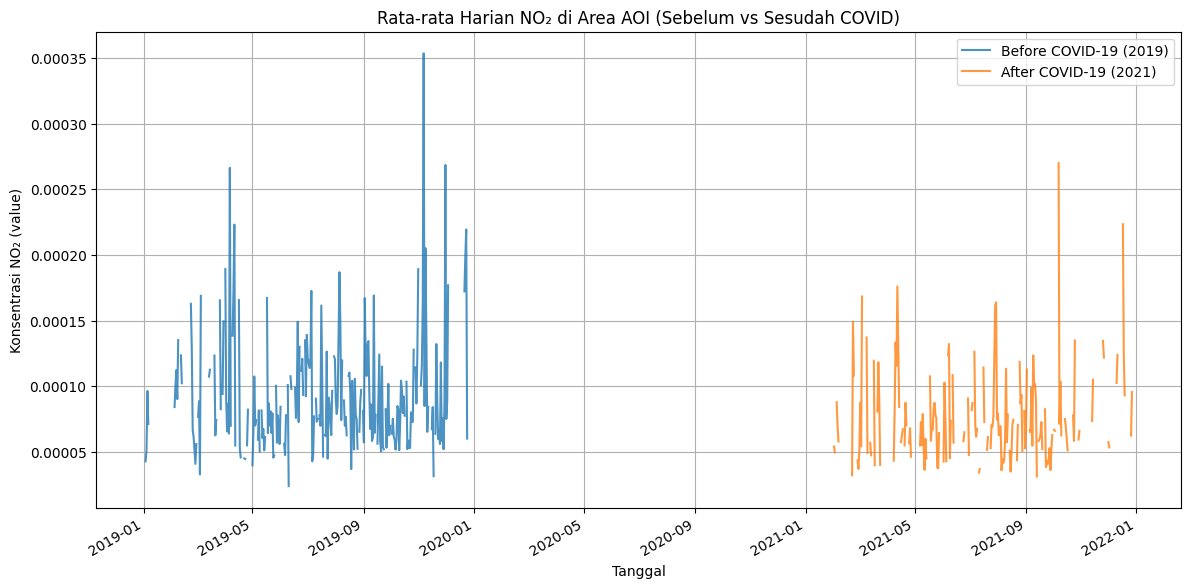

In [16]:
plt.figure(figsize=(14, 7))

# Plot 'before' (2019)
plt.plot(before_df['date'], before_df['value'], label="Before COVID-19 (2019)", alpha=0.8)

# Plot 'after' (2021)
plt.plot(after_df['date'], after_df['value'], label="After COVID-19 (2021)", alpha=0.8)

plt.title("Rata-rata Harian NO₂ di Area AOI (Sebelum vs Sesudah COVID)")
plt.xlabel("Tanggal")
plt.ylabel("Konsentrasi NO₂ (value)")
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate() 

plt.show()

## Preprocessing Data (Interpolasi Missing Values)

In [7]:
df = pd.concat([before_df, after_df])

print("5 baris pertama dari DataFrame gabungan (df):")
print(df.head())

print("\nNama kolom yang ada di df:")
print(df.columns)

# Menggunakan kolom 'value' yang sudah kita buat
df["value"] = df["value"].interpolate(method="linear")
df = df.dropna()

print("Data telah digabung dan diinterpolasi:")
print(df.head())

5 baris pertama dari DataFrame gabungan (df):
                       date     value
0 2019-01-01 00:00:00+00:00       NaN
1 2019-01-02 00:00:00+00:00       NaN
2 2019-01-03 00:00:00+00:00  0.000043
3 2019-01-04 00:00:00+00:00  0.000051
4 2019-01-05 00:00:00+00:00  0.000096

Nama kolom yang ada di df:
Index(['date', 'value'], dtype='object')
Data telah digabung dan diinterpolasi:
                       date     value
2 2019-01-03 00:00:00+00:00  0.000043
3 2019-01-04 00:00:00+00:00  0.000051
4 2019-01-05 00:00:00+00:00  0.000096
5 2019-01-06 00:00:00+00:00  0.000071
6 2019-01-07 00:00:00+00:00  0.000083


## Membentuk Data Supervised

In [8]:
def create_supervised(df, lag=3):
    data = pd.DataFrame()
    for i in range(1, lag + 1):
        data[f"lag_{i}"] = df["value"].shift(i) 
    data["target"] = df["value"] 
    data = data.dropna()
    return data

lag = 3
supervised_df = create_supervised(df, lag)
supervised_df.head()

,lag_1,lag_2,lag_3,target
5,0.000096,0.000051,0.000043,0.000071
6,0.000071,0.000096,0.000051,0.000083
7,0.000083,0.000071,0.000096,0.000094
8,0.000094,0.000083,0.000071,0.000106
9,0.000106,0.000094,0.000083,0.000117


## Normalisasi Data Training



In [9]:
# 1. Pisahkan fitur (X) dan target (y) dari data supervised
X = supervised_df.drop('target', axis=1)
y = supervised_df['target']

# 2. Bagi data menjadi training dan testing SET SEBELUM normalisasi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# 3. Buat scaler terpisah untuk X (fitur) dan y (target)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

print(f"Melakukan fit scaler pada {len(X_train)} baris data training...")
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

print(f"Melakukan transform pada {len(X_test)} baris data testing...")
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

print("Normalisasi data training & testing selesai.")

Melakukan fit scaler pada 570 baris data training...
Melakukan transform pada 143 baris data testing...
Normalisasi data training & testing selesai.


## Model KNN Regression & Evaluasi Metrik


In [14]:
# 1. Latih model menggunakan data training yang sudah dinormalisasi
model = KNeighborsRegressor(n_neighbors=5)
# Kita gunakan .ravel() untuk mengubah y_train_scaled kembali ke 1D array
model.fit(X_train_scaled, y_train_scaled.ravel())

# 2. Lakukan prediksi pada data test yang sudah dinormalisasi
y_pred_scaled = model.predict(X_test_scaled)

# 3. INVERSE TRANSFORM: Kembalikan prediksi ke skala aslinya
y_pred_actual = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

y_test_actual = scaler_y.inverse_transform(y_test_scaled)

print("--- Metrik Evaluasi Model (pada Test Set) ---")

mse = mean_squared_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)

print(f"R-squared (R2): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.10f}")
print(f"Mean Absolute Error (MAE): {mae:.10f}")

mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f} (atau {mape*100:.2f}%)")

--- Metrik Evaluasi Model (pada Test Set) ---
R-squared (R2): 0.4342
Mean Squared Error (MSE): 0.0000000008
Mean Absolute Error (MAE): 0.0000196430
Mean Absolute Percentage Error (MAPE): 0.2598 (atau 25.98%)


## Visualisasi Hasil Prediksi (Test Set)


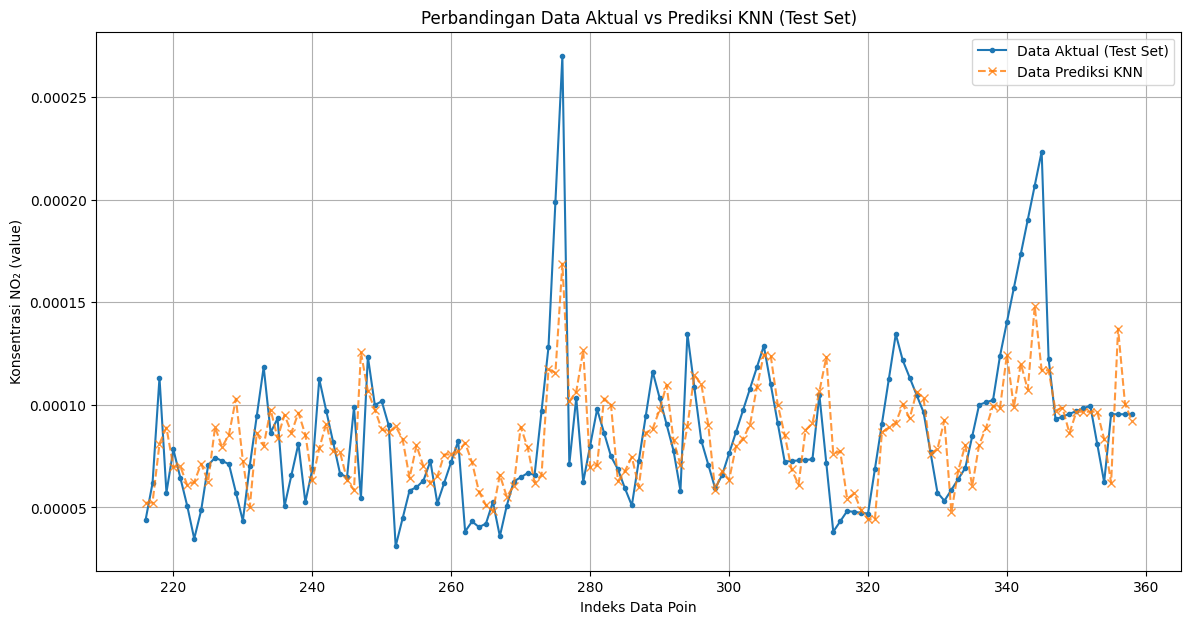

In [11]:
plt.figure(figsize=(14, 7))

plot_index = y_test.index

plt.plot(plot_index, y_test_actual, label="Data Aktual (Test Set)", marker='.', linestyle='-')
plt.plot(plot_index, y_pred_actual, label="Data Prediksi KNN", marker='x', linestyle='--', alpha=0.8)

plt.title("Perbandingan Data Aktual vs Prediksi KNN (Test Set)")
plt.xlabel("Indeks Data Poin")
plt.ylabel("Konsentrasi NO₂ (value)")
plt.legend()
plt.grid(True)
plt.show()

## Forecasting 5 hari ke Depan


In [20]:
print("Memulai forecast 5 hari ke depan...")

# 1. Tentukan jumlah hari untuk forecast
n_forecast = 5
last_lags_scaled = X_test_scaled[-1]

# List untuk menyimpan hasil forecast (yang masih ternormalisasi)
forecast_scaled = []

# 2. Loop untuk 5 hari
for _ in range(n_forecast):
    current_input = last_lags_scaled.reshape(1, -1)
    pred_next_scaled = model.predict(current_input)
    
    # Simpan hasil prediksi
    forecast_scaled.append(pred_next_scaled[0])
    new_lags = np.roll(last_lags_scaled, -1)
    new_lags[-1] = pred_next_scaled[0]
    last_lags_scaled = new_lags

forecast_actual = scaler_y.inverse_transform(np.array(forecast_scaled).reshape(-1, 1))


last_date = df['date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_forecast)

# 6. Buat DataFrame forecast
forecast_df = pd.DataFrame({'date': forecast_dates, 'forecast_value': forecast_actual.flatten()})

print("Forecast 5 hari selesai.")
print(forecast_df.head())

Memulai forecast 5 hari ke depan...
Forecast 5 hari selesai.
                       date  forecast_value
0 2021-12-31 00:00:00+00:00        0.000092
1 2022-01-01 00:00:00+00:00        0.000091
2 2022-01-02 00:00:00+00:00        0.000096
3 2022-01-03 00:00:00+00:00        0.000093
4 2022-01-04 00:00:00+00:00        0.000093


## Plot Actual NO2 (Setelah Covid) vs Prediksi Forecast


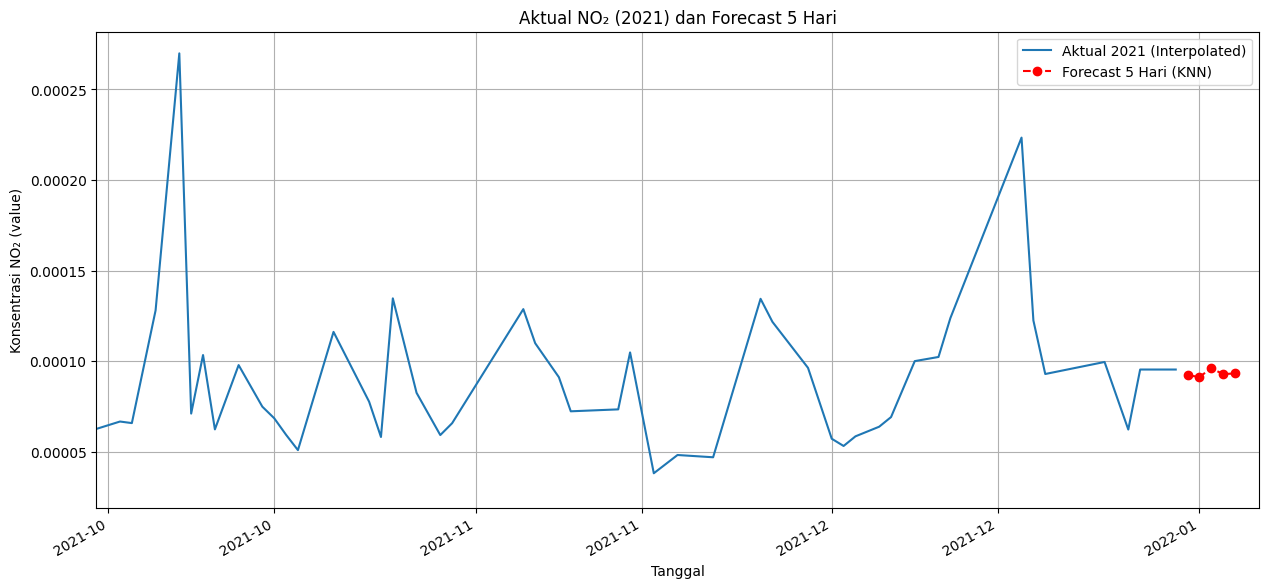

In [22]:
plt.figure(figsize=(15, 7))

actual_2021_interpolated = df[df['date'].dt.year == 2021]

plt.plot(actual_2021_interpolated['date'], actual_2021_interpolated['value'], label="Aktual 2021 (Interpolated)")


plt.plot(forecast_df['date'], forecast_df['forecast_value'], label="Forecast 5 Hari (KNN)", linestyle='--', color='red', marker='o')

plt.title("Aktual NO₂ (2021) dan Forecast 5 Hari")
plt.xlabel("Tanggal")
plt.ylabel("Konsentrasi NO₂ (value)")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()


plot_start_date = actual_2021_interpolated['date'].iloc[-90] 
plot_end_date = forecast_df['date'].iloc[-1] + pd.Timedelta(days=2) 
plt.xlim(plot_start_date, plot_end_date)

plt.show()